In [1]:
%matplotlib notebook

import numpy as np

import matplotlib.pyplot as plt

from mpmath import polylog

import scipy 
from scipy import sparse
from scipy.sparse import linalg as spla


In [2]:
def build_generator(N, vs, vd, ve, n=1, dense=False, half=False):
    
    # Inverter transistors 
    
    g_s = np.exp(-vs-ve/2)
    g_d = np.exp(-vd-ve/2)
   
    #Rates for the system
    lpn_s = lambda q1, q2: np.exp((vs + q2*ve)/n)
    lmn_s = lambda q1, q2: lpn_s(q1, q2)*g_s*np.exp(-q1*ve)
        
    lpp_s = lambda q1, q2: np.exp((vs - q2*ve)/n)
    lmp_s = lambda q1, q2: lpp_s(q1, q2)*g_s*np.exp(q1*ve)
    
    #Rates for the demon
    lpn_d = lambda q1, q2: np.exp((vd + q2*ve)/n)
    lmn_d = lambda q1, q2: lpn_d(q1, q2)*g_d*np.exp(-q1*ve)
        
    lpp_d = lambda q1, q2: np.exp((vd - q2*ve)/n)
    lmp_d = lambda q1, q2: lpp_d(q1, q2)*g_d*np.exp(q1*ve)
    
    # Net rates
    
    A1 = lambda q1, q2: lpp_s(q1, q2) + lmn_s(q1, q2) # rate for a transition q1 ->  q1 + qe
    B1 = lambda q1, q2: lmp_s(q1, q2) + lpn_s(q1, q2) # rate for a transition q1 ->  q1 - qe

    A2 = lambda q1, q2: lpp_d(q2, q1) + lmn_d(q2, q1) # rate for a transition q2 ->  q2 + qe
    B2 = lambda q1, q2: lmp_d(q2, q1) + lpn_d(q2, q1) # rate for a transition q2 ->  q2 - qe

        
    rows = []
    cols = []
    data = []
    
    if half:
        R1 = range(0,N+1)
        L1 = N+1
        map_ind = lambda q1, q2: q1 + L1*(N+q2)
    else:
        R1 = range(-N,N+1)
        L1 = 2*N+1
        map_ind = lambda q1, q2: N+q1 + L1*(N+q2)
    
    for q1 in R1:
        for q2 in range(-N,N+1):
            
            ind = map_ind(q1, q2)
            
            if half:
                esc = B1(q1, q2)
            else:
                esc = 0
              
            # arrival from or escape to q1-qe
            if (not half and q1-1 >= -N) or (half and q1-1 >= 0):
                aux = map_ind(q1-1, q2)
                
                arr = A1(q1-1, q2)
                
                if not half:
                    esc += B1(q1, q2)

                rows.append(ind)
                cols.append(aux)
                data.append(arr)
                           
            # arrival from or escape to q1+qe
            if q1+1 <= N:
                aux = map_ind(q1+1, q2)

                arr = B1(q1+1, q2)
                esc += A1(q1, q2)
                
                rows.append(ind)
                cols.append(aux)
                data.append(arr)
 
                
            # arrival from or escape to q2-qe
            if q2-1 >= -N:
                aux = map_ind(q1, q2-1)

                arr = A2(q1, q2-1)
                esc += B2(q1, q2)

                rows.append(ind)
                cols.append(aux)
                data.append(arr)

                
            # arrival from or escape to q2+qe
            if q2+1 <= N:
                aux = map_ind(q1, q2+1)
                
                arr = B2(q1, q2+1)
                esc += A2(q1, q2)

                rows.append(ind)
                cols.append(aux)
                data.append(arr)

            # escape rate
        
            rows.append(ind) 
            cols.append(ind)
            data.append(-esc)                
    
    if dense:
        gen = np.zeros((L1*(2*N+1), L1*(2*N+1)))
        for r, c, d in zip(rows, cols, data):
            gen[r,c] = d
    else:          
        gen = sparse.coo_matrix((data, (rows, cols)))
    
    return gen


def decode_ss(ss, norm=True):
    
    if norm:
        ss = ss/np.sum(ss)
    
    N = int((np.sqrt(len(ss))-1)/2)
    
    P = np.zeros((2*N+1,2*N+1))
    
    for k in range(len(ss)):
        
        q2 = int(k/(2*N+1)) - N
        q1 = k%(2*N+1) - N
        
        P[N+q1,N+q2] = ss[k][0]
        
    return P

def var_change(P):
    
    N = int((P.shape[0]-1)/2)
    Q = np.zeros((4*N+1,4*N+1))
    
    print(N,Q.shape)
    
    for q1 in range(-N,N+1):
        for q2 in range(-N,N+1):
            
            d = q1 - q2
            s = q1 + q2 
            
            Q[2*N+d, 2*N+s] += P[N+q1,N+q2]
            
    
    return Q

def make_product(P):
    
    P0 = np.sum(P, axis=0)
    P1 = np.sum(P, axis=1)
    
    Q = np.zeros_like(P)
    
    N = int((P.shape[0]-1)/2)

    for q1 in range(-N,N+1):
        for q2 in range(-N,N+1):
            Q[N+q1, N+q2] = P1[N+q1]*P0[N+q2]

    return Q

def exact_g(V, Vd, n):

    if hasattr(V, '__iter__'):
        PLA = np.array([float(polylog(2,-np.exp(Vd+x*(1+2/n)))) for x in V])
        PLB = np.array([float(polylog(2,-np.exp(-Vd+x*(1+2/n)))) for x in V])
    else:
        PLA = float(polylog(2,-np.exp(Vd+V*(1+2/n))))
        PLB = float(polylog(2,-np.exp(-Vd+V*(1+2/n))))
        
    g = V*(2*Vd+V)
    g += (2*n/(n+2))*PLA
    g -= (2*n/(n+2))*PLB
    
    return g

def effective_potential_g(x, vd, slope=1):
    
    lpp = lambda v1, v2: np.exp((vd-v2)/slope)
    lmp = lambda v1, v2: lpp(v1, v2)*np.exp(-(vd-v1))

    lpn = lambda v1, v2: np.exp((vd+v2)/slope)
    lmn = lambda v1, v2: lpn(v1, v2)*np.exp(-(vd+v1))
    
    Am = lambda v1, v2: lpp(v1,v2) + lmn(v1,v2)
    Ap = lambda v1, v2: lmp(v1,v2) + lpn(v1,v2)
    
    
    alpha = (Am(-x,x) + Ap(x,-x))/(Am(x,-x) + Ap(-x,x))
    
    return 2*np.log(alpha)

def effective_potential_h(y, vd, xmin=0, slope=1):
    
    lpp = lambda v1, v2: np.exp((vd-v2)/slope)
    lmp = lambda v1, v2: lpp(v1, v2)*np.exp(-(vd-v1))

    lpn = lambda v1, v2: np.exp((vd+v2)/slope)
    lmn = lambda v1, v2: lpn(v1, v2)*np.exp(-(vd+v1))
    
    Am = lambda v1, v2: lpp(v1,v2) + lmn(v1,v2)
    Ap = lambda v1, v2: lmp(v1,v2) + lpn(v1,v2)
    
    v1 = xmin + y
    v2 = -xmin + y
    
    beta = (Ap(xmin + y,-xmin + y) + Ap(-xmin + y,xmin + y))/(Am(xmin + y,-xmin + y) + Am(-xmin + y,xmin + y))
    
    return 2*np.log(beta)


def average_currents(P,Vd_o_Vth, qe_o_qth, n=1):
    
    g = np.exp(-Vd_o_Vth-qe_o_qth/2)
    
    lpn = lambda q1, q2: np.exp((Vd_o_Vth + q2*qe_o_qth)/n)
    lmn = lambda q1, q2: lpn(q1, q2)*g*np.exp(-q1*qe_o_qth)
        
    lpp = lambda q1, q2: np.exp((Vd_o_Vth - q2*qe_o_qth)/n)
    lmp = lambda q1, q2: lpp(q1, q2)*g*np.exp(q1*qe_o_qth)
    
    
    N = int((P.shape[0]-1)/2)
    
    In = Ip = 0
           
    for q1 in range(-N,N+1):
        for q2 in range(-N,N+1):
            
            In += (lpn(q1,q2) - lmn(q1,q2))*P[N+q1,N+q2]
            Ip += (lpp(q1,q2) - lmp(q1,q2))*P[N+q1,N+q2]
            
    return In, Ip


def approx_g_1st(V, Vd, n):

    g = V**2 - 4*Vd*(n/(n+2))*np.log(2*np.cosh((V/2)*(n+2)/n))
    
    return g




In [3]:
vd = 1.3
vs = 1.3
ve =  0.1
slope = 1.0

N = 30

print("Building generator...")
G = build_generator(N, vs, vd, ve)
print("Computing steady state...")
ss = spla.eigs(sparse.csr_matrix(G), k=1, which='SM')
Pss = decode_ss(ss[1])


Building generator...
Computing steady state...


/tmp/ipykernel_77253/3908923201.py:132: ComplexWarning: Casting complex values to real discards the imaginary part
  P[N+q1,N+q2] = ss[k][0]


<IPython.core.display.Javascript object>


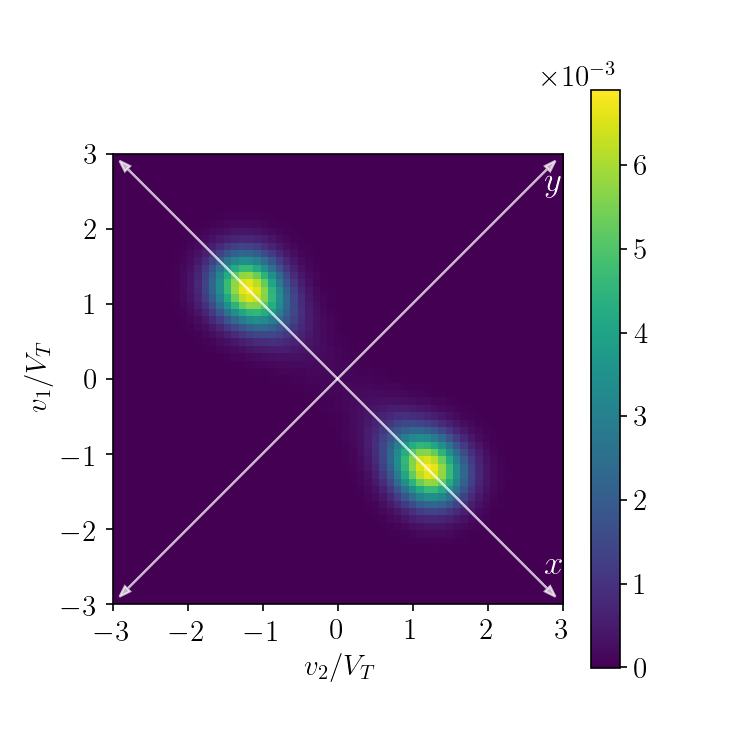

In [5]:
#Direct input 
plt.rcParams['text.latex.preamble']=r"\usepackage{lmodern}"
#Options
params = {'text.usetex' : True,
          'font.size' : 14,
          'font.family' : 'lmodern',
          }
plt.rcParams.update(params) 


plt.figure(figsize=(5,5), dpi=150)
plt.gcf().subplots_adjust(left=.15, hspace=.1)


#plt.imshow(-np.log(Pss)*ve, origin='lower', extent=N*ve*np.array([-1,1,-1,1]))
plt.imshow(Pss, origin='lower', extent=N*ve*np.array([-1,1,-1,1]))
plt.xlabel(r'$v_2/V_T$')
plt.ylabel(r'$v_1/V_T$')
plt.xticks([-3,-2,-1,0,1,2,3])
#plt.xticks([-2,-1,0,1,2])

cbar = plt.colorbar()
cbar.formatter.set_powerlimits((0, 0))

plt.arrow(0,0,2.8,2.8, linestyle='-', color='white', alpha=.7, head_width=.1, linewidth=1)
plt.arrow(0,0,-2.8,-2.8, linestyle='-', color='white', alpha=.7, head_width=.1, linewidth=1)
plt.arrow(0,0,-2.8,2.8, linestyle='-', color='white', alpha=.7, head_width=.1, linewidth=1)
plt.arrow(0,0,2.8,-2.8, linestyle='-', color='white', alpha=.7, head_width=.1, linewidth=1)

plt.text(2.75,2.5,"$y$", color="white", fontsize="large")
plt.text(2.75,-2.6,"$x$", color="white", fontsize="large")

plt.savefig('ss_histogram.png')


In [6]:
from scipy.integrate import ode


def drift(t, V, vd):
    
    wp = lambda v1,v2: np.exp(vd-v2)
    wm = lambda v1,v2: wp(v1,v2)*np.exp(-vd+v1)
    
    I = lambda v1,v2: wp(v1,v2) - wm(v1,v2)
    
    u1 = I(V[0],V[1]) - I(-V[0],-V[1])
    u2 = I(V[1],V[0]) - I(-V[1],-V[0])
    
    return np.array([u1, u2])
    

def work_rate(V, vd):
    
    wp = lambda v1,v2: np.exp(vd-v2)
    wm = lambda v1,v2: wp(v1,v2)*np.exp(-vd+v1)
    
    I = lambda v1,v2: wp(v1,v2) - wm(v1,v2)
    
    W = vd*(I(V[0],V[1]) + I(-V[0],-V[1]) + I(V[1],V[0]) + I(-V[1],-V[0]))
    
    return W

# def heat_rate(V, vd):
    
#     wp = lambda v1,v2: np.exp(vd-v2)
#     wm = lambda v1,v2: wp(v1,v2)*np.exp(-vd+v1)
    
#     I = lambda v1,v2: wp(v1,v2) - wm(v1,v2)
    
#     Q = (vd-V[0])*I(V[0],V[1]) 
#     Q += (V[0]+vd)*I(-V[0],-V[1]) 
#     Q += (vd-V[1])*I(V[1],V[0])
#     Q += (V[1]+vd)*I(-V[1],-V[0])
    
#     return Q

def heat_rate(V, vd):
    
    wp = lambda v1,v2: np.exp(vd-v2)
    wm = lambda v1,v2: wp(v1,v2)*np.exp(-vd+v1)  
    
    Q = (wp(V[0],V[1]) - wm(V[0],V[1]))*np.log(wp(V[0],V[1])/wm(V[0],V[1])) 
    Q += (wp(-V[0],-V[1]) - wm(-V[0],-V[1]))*np.log(wp(-V[0],-V[1])/wm(-V[0],-V[1]))
    Q += (wp(V[1],V[0]) - wm(V[1],V[0]))*np.log(wp(V[1],V[0])/wm(V[1],V[0]))
    Q += (wp(-V[1],-V[0]) - wm(-V[1],-V[0]))*np.log(wp(-V[1],-V[0])/wm(-V[1],-V[0]))
    
    return Q


def energy(V):
    
    return .5*(V[0]**2 + V[1]**2)


def cg_heat_rate(V, vd):
    
    wp = lambda v1,v2: np.exp(vd-v2)
    wm = lambda v1,v2: wp(v1,v2)*np.exp(-vd+v1)  
    
    WP = lambda v1, v2: wp(v1,v2) + wm(-v1,-v2)
    WM = lambda v1, v2: wm(v1,v2) + wp(-v1,-v2)
    
    Q = (WP(V[0],V[1]) - WM(V[0],V[1]))*np.log(WP(V[0],V[1])/WM(V[0],V[1])) 
    Q += (WP(V[1],V[0]) - WM(V[1],V[0]))*np.log(WP(V[1],V[0])/WM(V[1],V[0]))
    
    return Q


In [7]:
def generate_trajectory(v0, vd, dt, Tf):

    r = ode(drift)
    r.set_initial_value(v0, 0).set_f_params(vd)

    T = [0]
    V = [v0]
    dt = 1e-5

    while r.successful() and r.t < Tf:
        T.append(r.t+dt)
        V.append(r.integrate(r.t+dt))

    cgQ = np.array([cg_heat_rate(v, vd) for v in V])
    bound = np.cumsum(cgQ)*dt
    bound = bound[-1] - bound
    
    return np.array(T), np.array(V), bound

<IPython.core.display.Javascript object>


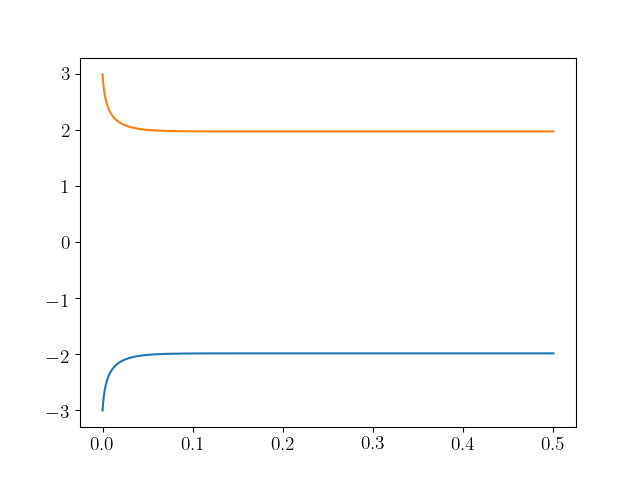

<IPython.core.display.Javascript object>


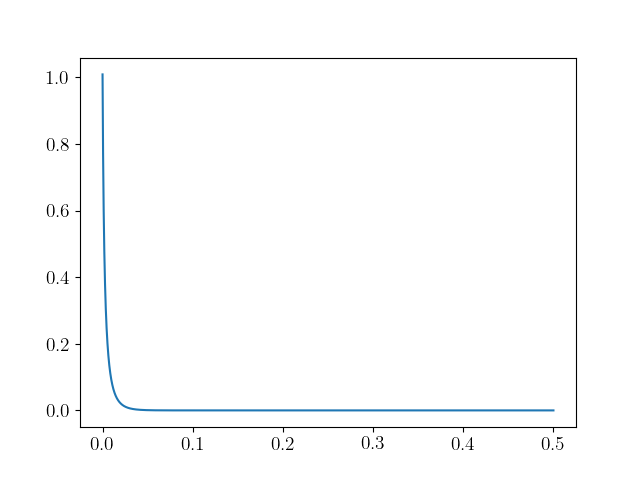

In [8]:
dt = 1e-3
T, V, bound = generate_trajectory([-3,3],2,dt,0.5)

plt.figure()
plt.plot(T, [v[0] for v in V])
plt.plot(T, [v[1] for v in V])


plt.figure()
plt.plot(T, bound)


In [11]:
dt = 1e-2
Tf = 0.8

Tr = []

print(vd)

J = 21
for j in range(J+1):
        print(j)
        
        T, V, bound  = generate_trajectory([1-4*j/J,-3+4*j/J],vd,dt,Tf)
        Tr.append((T,V,bound))
        T, V, bound  = generate_trajectory([3-4*j/J,-1+4*j/J],vd,dt,Tf)
        Tr.append((T,V,bound))
    
    
J = 8
Tf = 1.5
for j in range(J+1):
        print(j)
        
        T, V, bound  = generate_trajectory([1+2*j/J,-3+2*j/J],vd,dt,Tf)
        Tr.append((T,V,bound))
        T, V, bound  = generate_trajectory([-3+2*j/J,1+2*j/J],vd,dt,Tf)
        Tr.append((T,V,bound))
        T, V, bound  = generate_trajectory([-1+2*j/J-.05,-1+2*j/J+.05],vd,dt,Tf)
        Tr.append((T,V,bound))
        T, V, bound  = generate_trajectory([-1+2*j/J+.05,-1+2*j/J-.05],vd,dt,Tf)
        Tr.append((T,V,bound))
        
        
J = 9
Tf = 1.5
for j in range(J+1):
        print(j)
        
        T, V, bound  = generate_trajectory([-.5-j/J,-1.5+j/J],vd,dt,Tf)
        Tr.append((T,V,bound))
        T, V, bound  = generate_trajectory([1.5-1*j/J,0.5+1*j/J],vd,dt,Tf)
        Tr.append((T,V,bound))

1.3
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
0
1
2
3
4
5
6
7
8
0
1
2
3
4
5
6
7
8
9


<IPython.core.display.Javascript object>


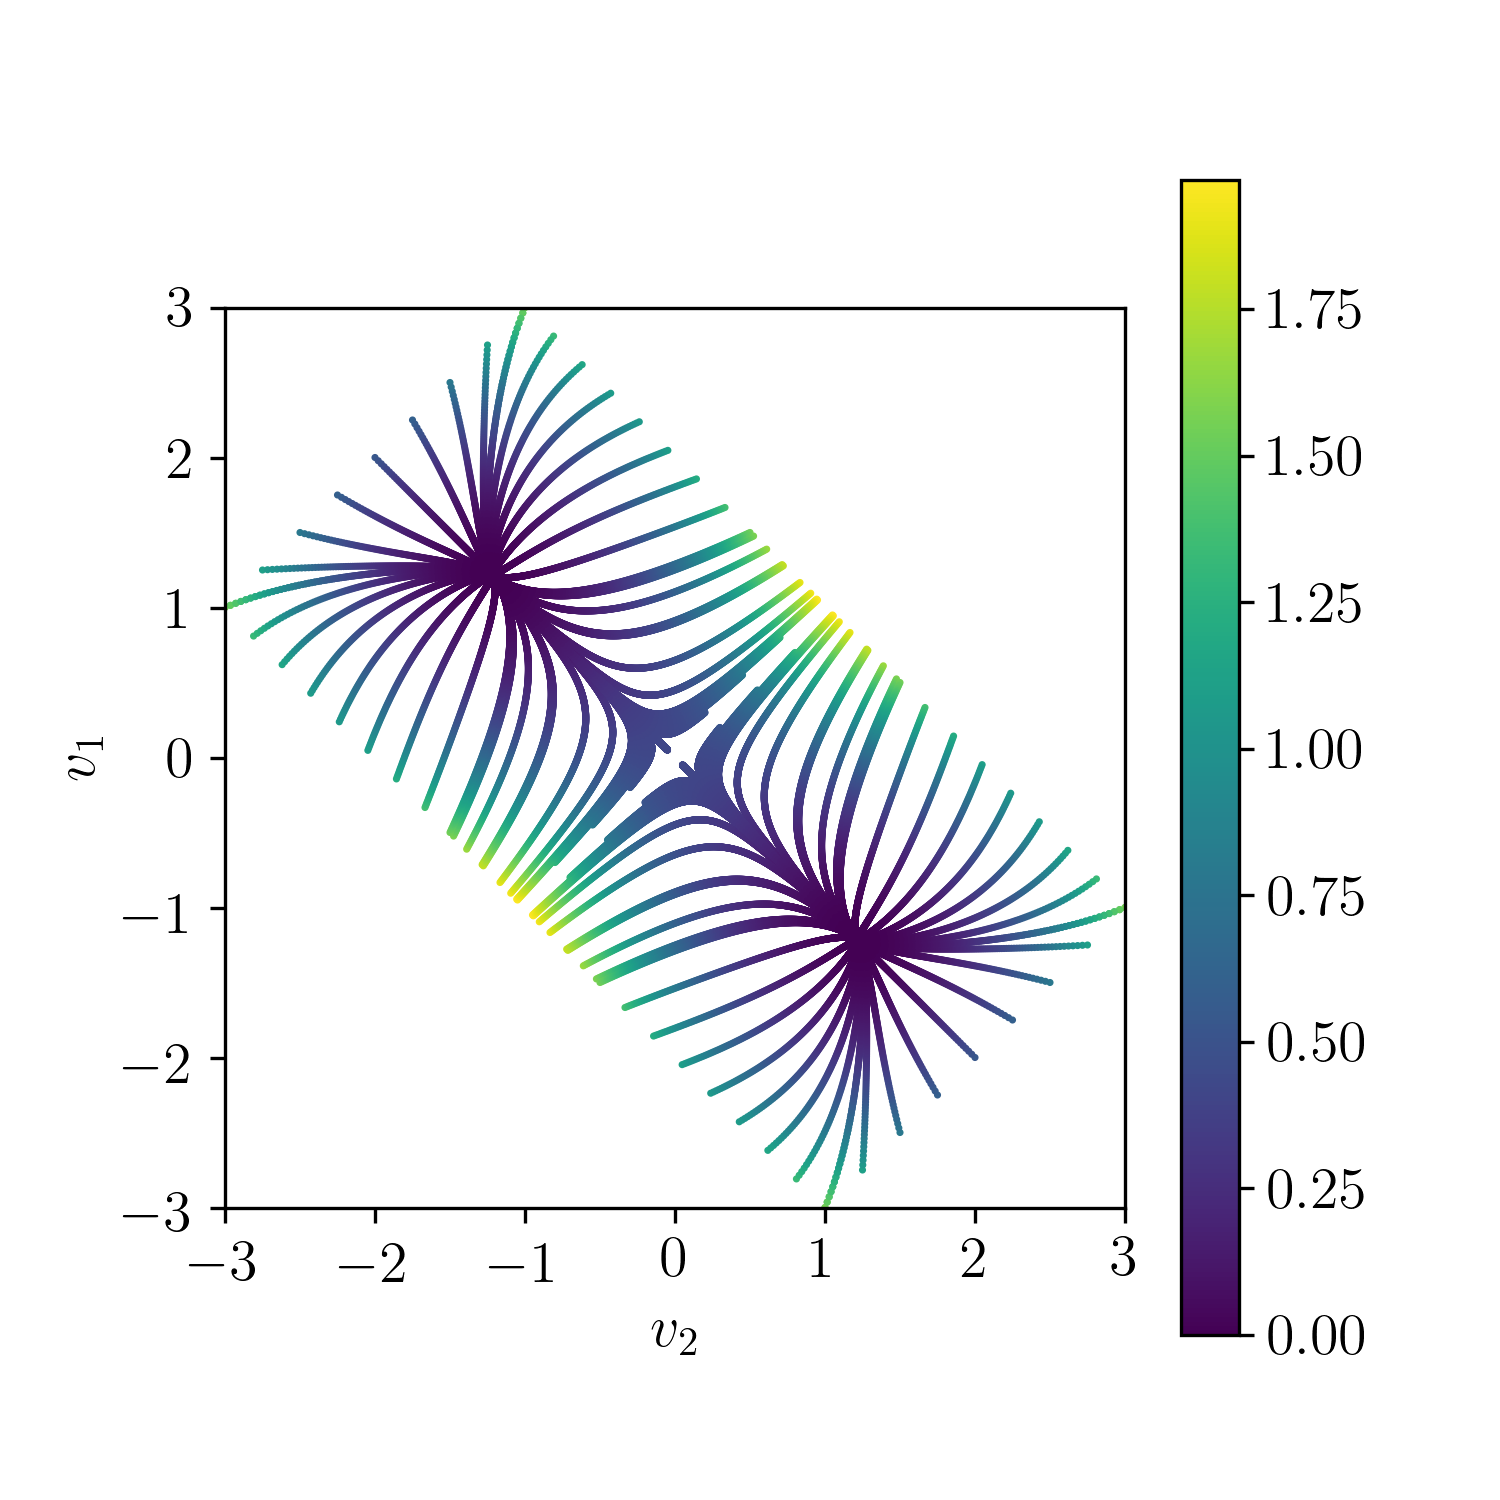

In [12]:
#Direct input 
plt.rcParams['text.latex.preamble']=r"\usepackage{lmodern}"
#Options
params = {'text.usetex' : True,
          'font.size' : 14,
          'font.family' : 'lmodern',
          }
plt.rcParams.update(params) 


plt.figure(figsize=(5,5), dpi=300)
plt.gcf().subplots_adjust(left=.15, hspace=.1)


V1 = np.empty(0)
V2 = np.empty(0)
B = np.empty(0)

for T, V, bound in Tr:
    
    V = np.array(V)

    V1 = np.concatenate((V1,V[:,0][::80]))
    V2 = np.concatenate((V2,V[:,1][::80]))
    B = np.concatenate((B,bound[::80]))
    
#Pr = B#np.exp(-B/ve)
#Pr = Pr/np.sum(Pr)

plt.imshow(np.zeros_like(Pss), origin='lower', extent=N*ve*np.array([-1,1,-1,1]),cmap='binary')
plt.scatter(V1, V2, c=B,s=.5)

plt.xlabel(r'$v_2$')
plt.ylabel(r'$v_1$')
plt.xticks([-3,-2,-1,0,1,2,3])

plt.colorbar()

plt.savefig('mesh_trajectories.png')


def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)
    
#set_size(6,5)

In [14]:
grid_x, grid_y = np.mgrid[-3:3:61j, -3:3:61j]
from scipy.interpolate import griddata

grid_z0 = griddata(np.array([V1,V2]).T, B, (grid_x, grid_y), method='linear')
#grid_z0[np.isnan(grid_z0)]=30
#grid_z0 = grid_z0/np.sum(grid_z0)


<IPython.core.display.Javascript object>


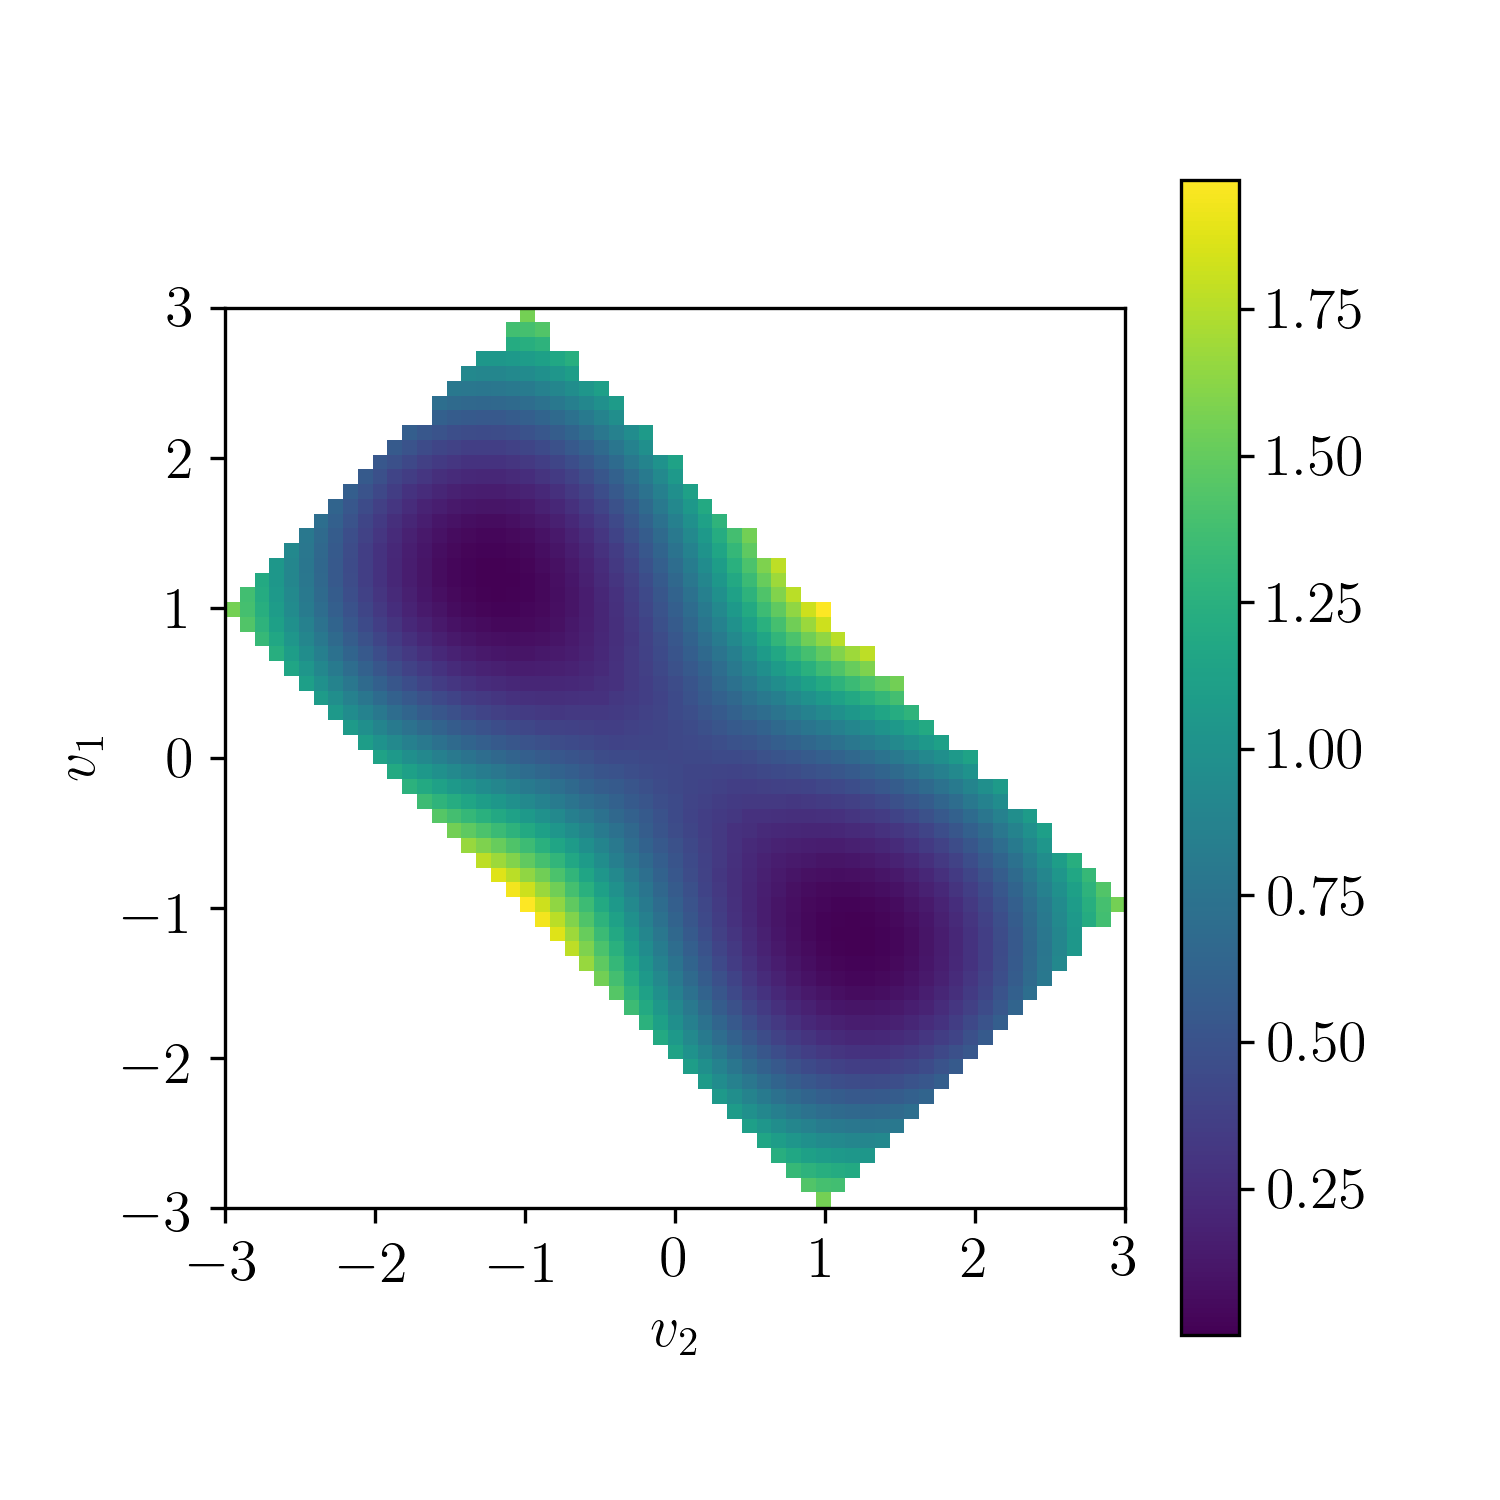

In [15]:
#Direct input 
plt.rcParams['text.latex.preamble']=r"\usepackage{lmodern}"
#Options
params = {'text.usetex' : True,
          'font.size' : 14,
          'font.family' : 'lmodern',
          }
plt.rcParams.update(params) 


plt.figure(figsize=(5,5), dpi=300)
plt.gcf().subplots_adjust(left=.15, hspace=.1)


#plt.imshow(-np.log(Pss)*ve, origin='lower', extent=N*ve*np.array([-1,1,-1,1]))
plt.imshow(grid_z0, origin='lower', extent=N*ve*np.array([-1,1,-1,1]))
plt.xlabel(r'$v_2$')
plt.ylabel(r'$v_1$')
plt.xticks([-3,-2,-1,0,1,2,3])


cbar = plt.colorbar()
cbar.formatter.set_powerlimits((0, 0))

plt.savefig('interpolated_rate_func.png')



<IPython.core.display.Javascript object>


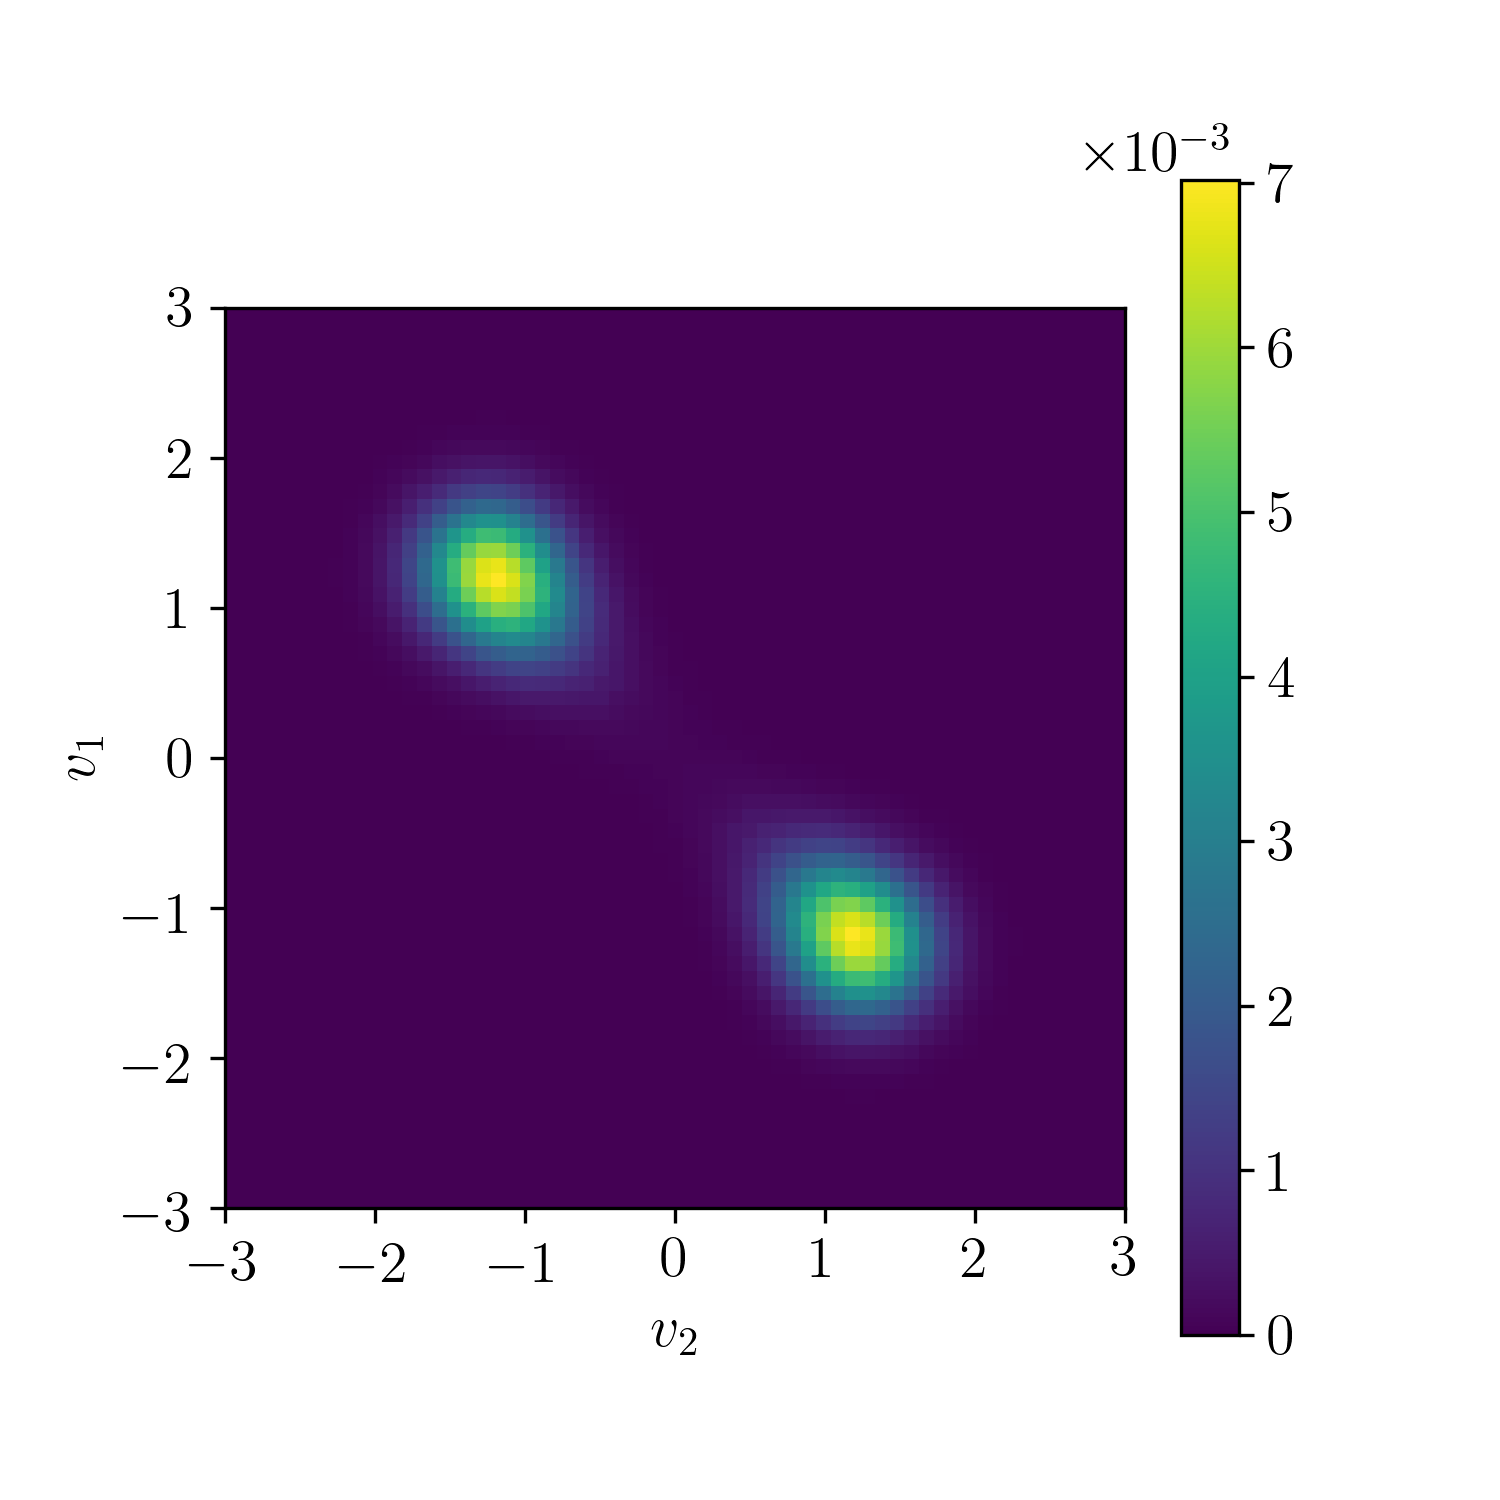

In [16]:
#Direct input 
plt.rcParams['text.latex.preamble']=r"\usepackage{lmodern}"
#Options
params = {'text.usetex' : True,
          'font.size' : 14,
          'font.family' : 'lmodern',
          }
plt.rcParams.update(params) 


plt.figure(figsize=(5,5), dpi=300)
plt.gcf().subplots_adjust(left=.15, hspace=.1)

PR = np.exp(-grid_z0/ve)
PR[np.isnan(PR)] = 0
PR = PR/np.sum(PR)

#plt.imshow(-np.log(Pss)*ve, origin='lower', extent=N*ve*np.array([-1,1,-1,1]))
plt.imshow(PR, origin='lower', extent=N*ve*np.array([-1,1,-1,1]))
plt.xlabel(r'$v_2$')
plt.ylabel(r'$v_1$')
plt.xticks([-3,-2,-1,0,1,2,3])

cbar = plt.colorbar()
cbar.formatter.set_powerlimits((0, 0))

plt.savefig('reconstructed_Pss.png')


<IPython.core.display.Javascript object>


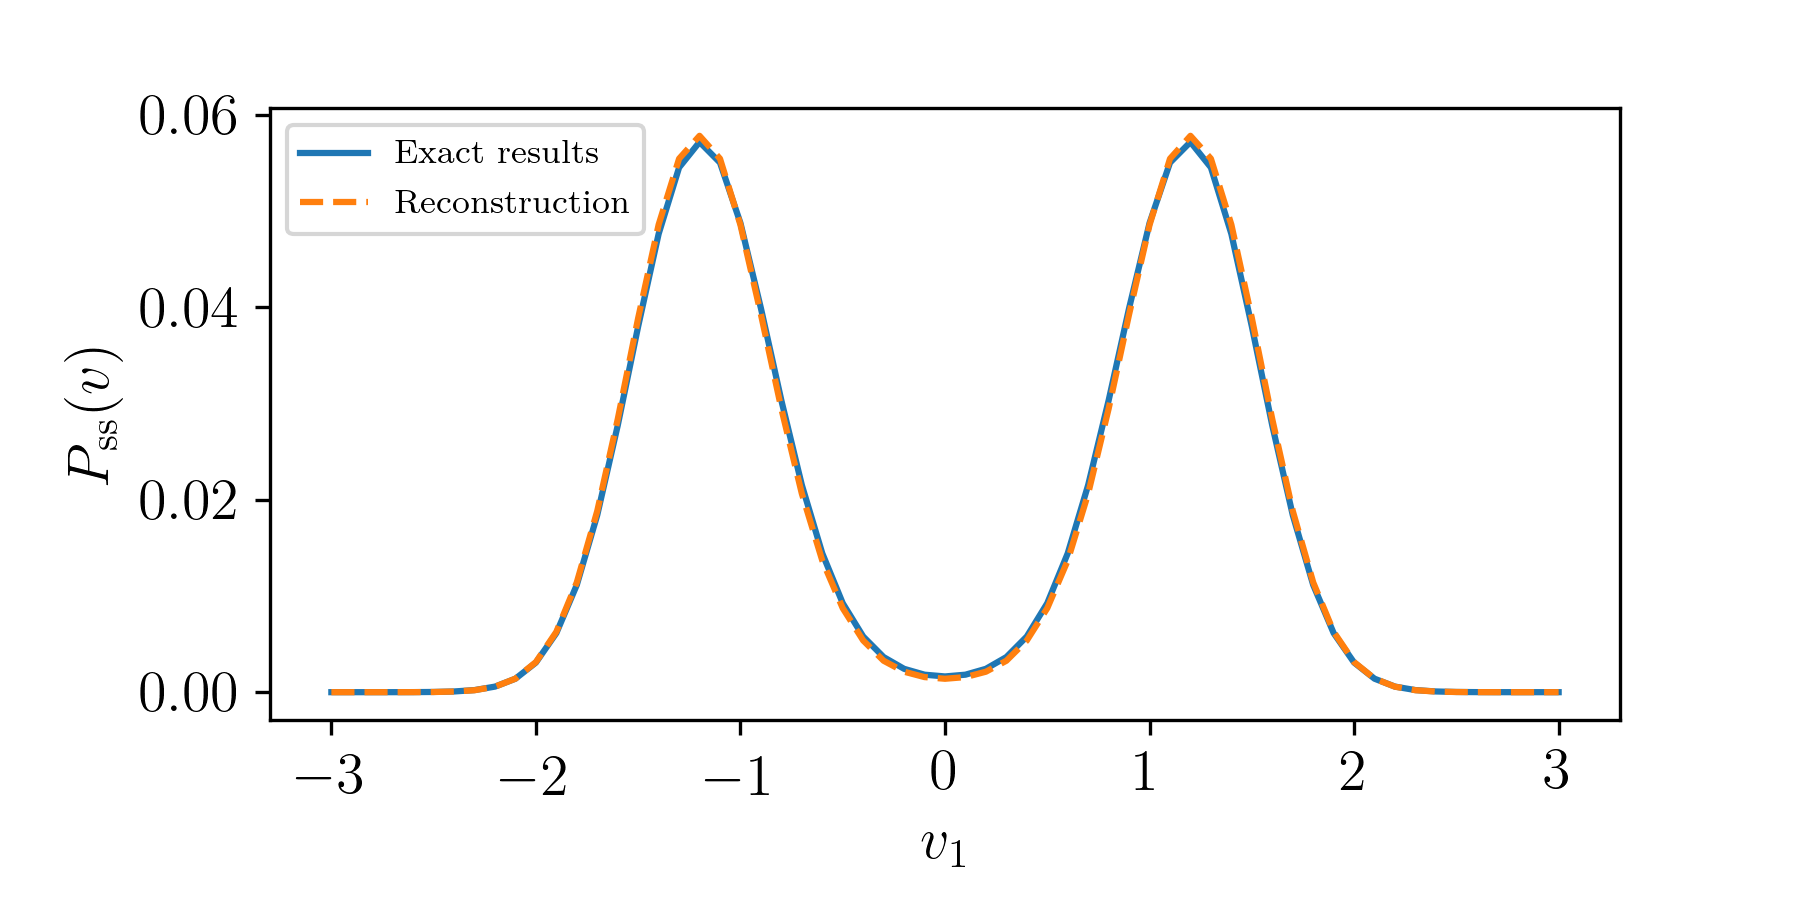

findfont: Font family ['lmodern'] not found. Falling back to DejaVu Sans.


In [17]:
#Direct input 
plt.rcParams['text.latex.preamble']=r"\usepackage{lmodern}"
#Options
params = {'text.usetex' : True,
          'font.size' : 14,
          'font.family' : 'lmodern',
          }
plt.rcParams.update(params) 


plt.figure(figsize=(6,3), dpi=300)
plt.gcf().subplots_adjust(left=.15, bottom=.2,hspace=.1)

plt.plot(ve*np.arange(-30,31),np.sum(Pss, axis=0))
plt.plot(ve*np.arange(-30,31),np.sum(PR, axis=0), '--')

plt.xlabel(r'$v_1$')
plt.ylabel(r'$P_\mathrm{ss}(v)$')

plt.legend(["Exact results", "Reconstruction"], fontsize="xx-small", loc="upper left")

plt.savefig("rec_comp.png")